In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from dkeras import dKeras
import datetime
import cProfile
import matplotlib.pyplot as plt
from AQIDataset import AQIDataset, AQIDataGenerator

In [3]:
data = pd.read_csv('data/aqi_daily_1980_to_2021.csv')
data['Date'] = data['Date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
data.loc[data['AQI']>500, 'AQI'] = 500  # truncate AQI values at 500

<AxesSubplot:>

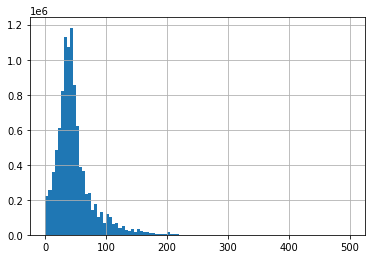

In [4]:
data['AQI'].hist(bins=100)

In [5]:
dataset = AQIDataset(
    df=data, 
    batch_size=32, 
    input_size=(28,), 
    output_size=(14,), 
    train_test_split=0.8, 
    feature_scaling='01',
)

/Users/Nikhil/Developer/us-aqi/venv/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [6]:
trg = AQIDataGenerator(dataset, dataset.locations_train)
teg = AQIDataGenerator(dataset, dataset.locations_test)

In [7]:
n_hidden = 100

In [8]:
input_train = tf.keras.Input(shape=(dataset.input_size[0], 1), batch_size=dataset.batch_size)
output_train = tf.keras.Input(shape=dataset.output_size)
print(input_train)
print(output_train)

KerasTensor(type_spec=TensorSpec(shape=(32, 28, 1), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 14), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


In [9]:
encoder = tf.keras.layers.LSTM(
    n_hidden, 
    activation='elu', 
    dropout=0.2, 
    recurrent_dropout=0.2, 
    return_sequences=True, 
    return_state=True,
    kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
    bias_regularizer=tf.keras.regularizers.l2(1e-4),
    activity_regularizer=tf.keras.regularizers.l2(1e-5)
)
encoder_stack_h, encoder_last_h, encoder_last_c = encoder(input_train)
print(encoder_stack_h)
print(encoder_last_h)
print(encoder_last_c)

KerasTensor(type_spec=TensorSpec(shape=(32, 28, 100), dtype=tf.float32, name=None), name='lstm/transpose_1:0', description="created by layer 'lstm'")
KerasTensor(type_spec=TensorSpec(shape=(32, 100), dtype=tf.float32, name=None), name='lstm/while:4', description="created by layer 'lstm'")
KerasTensor(type_spec=TensorSpec(shape=(32, 100), dtype=tf.float32, name=None), name='lstm/while:5', description="created by layer 'lstm'")


In [10]:
encoder_last_h = tf.keras.layers.BatchNormalization(momentum=0.6)(encoder_last_h)
encoder_last_c = tf.keras.layers.BatchNormalization(momentum=0.6)(encoder_last_c)
print(encoder_last_h)
print(encoder_last_c)

KerasTensor(type_spec=TensorSpec(shape=(32, 100), dtype=tf.float32, name=None), name='batch_normalization/batchnorm/add_1:0', description="created by layer 'batch_normalization'")
KerasTensor(type_spec=TensorSpec(shape=(32, 100), dtype=tf.float32, name=None), name='batch_normalization_1/batchnorm/add_1:0', description="created by layer 'batch_normalization_1'")


In [11]:
decoder_input = tf.keras.layers.RepeatVector(output_train.shape[1])(encoder_last_h)
decoder_stack_h = tf.keras.layers.LSTM(
    n_hidden, 
    activation='elu', 
    dropout=0.2, 
    recurrent_dropout=0.2,
    return_state=False, 
    return_sequences=True
)(decoder_input, initial_state=[encoder_last_h, encoder_last_c])
print(decoder_stack_h)

KerasTensor(type_spec=TensorSpec(shape=(32, 14, 100), dtype=tf.float32, name=None), name='lstm_1/transpose_1:0', description="created by layer 'lstm_1'")


In [12]:
attention = tf.keras.layers.dot([decoder_stack_h, encoder_stack_h], axes=[2, 2])
attention = tf.keras.layers.Activation('softmax')(attention)
print(attention)

KerasTensor(type_spec=TensorSpec(shape=(32, 14, 28), dtype=tf.float32, name=None), name='activation/Softmax:0', description="created by layer 'activation'")


In [13]:
context = tf.keras.layers.dot([attention, encoder_stack_h], axes=[2, 1])
context = tf.keras.layers.BatchNormalization(momentum=0.6)(context)
print(context)

KerasTensor(type_spec=TensorSpec(shape=(32, 14, 100), dtype=tf.float32, name=None), name='batch_normalization_2/batchnorm/add_1:0', description="created by layer 'batch_normalization_2'")


In [14]:
decoder_combined_context = tf.keras.layers.concatenate([context, decoder_stack_h])
print(decoder_combined_context)

KerasTensor(type_spec=TensorSpec(shape=(32, 14, 200), dtype=tf.float32, name=None), name='concatenate/concat:0', description="created by layer 'concatenate'")


In [15]:
output = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))(decoder_combined_context)
print(output)

KerasTensor(type_spec=TensorSpec(shape=(32, 14, 1), dtype=tf.float32, name=None), name='time_distributed/Reshape_1:0', description="created by layer 'time_distributed'")


In [16]:
model = tf.keras.Model(inputs=input_train, outputs=output)
opt = tf.keras.optimizers.Adam(learning_rate=0.001, clipvalue=0.5)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(32, 28, 1)]        0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(32, 28, 100), (32, 40800       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (32, 100)            400         lstm[0][1]                       
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (32, 14, 100)        0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
epochs = 100
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=50)
history = model.fit(trg, validation_data=teg, epochs=epochs, verbose=1, callbacks=[es], batch_size=dataset.batch_size)
train_mae = history.history['mae']
valid_mae = history.history['val_mae']

In [ ]:
model.save('m')